## Importing the dataset

I use the the "The Oxford-IIIT Pet Dataset" from [https://www.robots.ox.ac.uk/~vgg/data/pets/](https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz). 

Once downloaded the tarball contains a single folder called `images`, which contains both the cat and dog photos. In this particular dataset, the label of the image is in the filename. Particularly, the first letter of the filename is capital if the image were that of a cat (like `Persian_80.jpg`) and lowercase if its a dog photo (like `keeshond_130.jpg`).

So, once I extract the tarball, I move cats and dogs into their own subfolder. Once I do that the folder structure is as follows:

- pet_photos
    - dogs
        - yorkshire_terrier_93.jpg
        - german_shorthaired_118.jpg
        - ...
    - cats
        - Bombay_75.jpg
        - Sphynx_84.jpg
        - ...

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib

plt.style.use('dark_background')

# Making sure tensorflow is working properly
print("TensorFlow Versions: ", tf.__version__)
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

# This prevents some error messages caused by reaching memory limits
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


TensorFlow Versions:  2.7.0
TensorFlow **IS** using the GPU


In [2]:
data_dir = pathlib.Path('/home/addy/.keras/datasets/pets_photos/')

if data_dir.exists():
    print("Found the 'pets_photos' dataset.")

else:
    print("Downloading 'pets_photos' dataset.")
    
    # Downloading and formatting the "The Oxford-IIIT Pet Dataset" from 
    # https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

    dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                    fname='pets_photos',
                                    untar=True)
    data_dir = pathlib.Path(data_dir)


    # Delete the tar file (which keras doesn't delete for some reason) 
    # and move the images folder into the new pets_photos folder
    # This code might need to be changed based on your system config

    !rm ~/.keras/datasets/pets_photos.tar.gz
    !mkdir ~/.keras/datasets/pets_photos
    !mv ~/.keras/datasets/images ~/.keras/datasets/pets_photos/images


    # Move cats and dogs into their own subfolder so that the 
    # tf.keras.utils.image_dataset_from_directory function can pickup
    # categories from the folder structure.

    images_dir = data_dir / 'images'
    cats_dir = data_dir / 'cats'
    dogs_dir = data_dir / 'dogs'

    cats_dir.mkdir()
    dogs_dir.mkdir()

    f = []
    for (dirpath, dirnames, filenames) in os.walk(images_dir):
        for file in filenames:
            # The cats' image filenames start with an uppercase letter ¯\_(ツ)_/¯
            if file[0].isupper():
                os.rename(images_dir / file, cats_dir / file)
            else:
                os.rename(images_dir / file, dogs_dir / file)


    # Finally delete the images folder. All photos should be under 
    # their proper categorical folder.
    !rm -r ~/.keras/datasets/pets_photos/images

Found the 'pets_photos' dataset.


In [3]:
dogs_count = len(list(data_dir.glob('dogs/*.jpg')))
cats_count = len(list(data_dir.glob('cats/*.jpg')))
all_count = cats_count + dogs_count
print("Data Directory: ", data_dir)
print("Number of total .jpg files: ", all_count)
print("Number of .jpg images in /cats/: ", cats_count)
print("Number of .jpg images in /dogs/: ", dogs_count)


Data Directory:  /home/addy/.keras/datasets/pets_photos
Number of total .jpg files:  7390
Number of .jpg images in /cats/:  2400
Number of .jpg images in /dogs/:  4990


## Loading the datasets


Since the appropriate folder structure has been created, I call the `tf.keras.utils.image_dataset_from_directory` function to import the dataset. This function scans the dataset folder for images and automatically labels each image with the name of the directory it is found in.

In [4]:
# Initializing parameters

batch_size = 32     # Reduce this if you get memory errors

img_height = 160    # I'm keeping this at 160 for no particular reason 
img_width = 160     # (there is a reason, I'll share in a future blog post)

seed = 120          # A random seed to get replicable results

epochs = 10         # The number of training epochs

In [7]:
# Initializing the training dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 7390 files belonging to 2 classes.
Using 5912 files for training.


Once the dataset is initialized, I do some basic sanity checks to make sure the labels are correct. I wasted a lot of time because of a bug here because the labels were not imported properly and the classifier was stuck at an accuracy of 0.66 (which is what you'll get if you guess that all the images are of that of dogs)

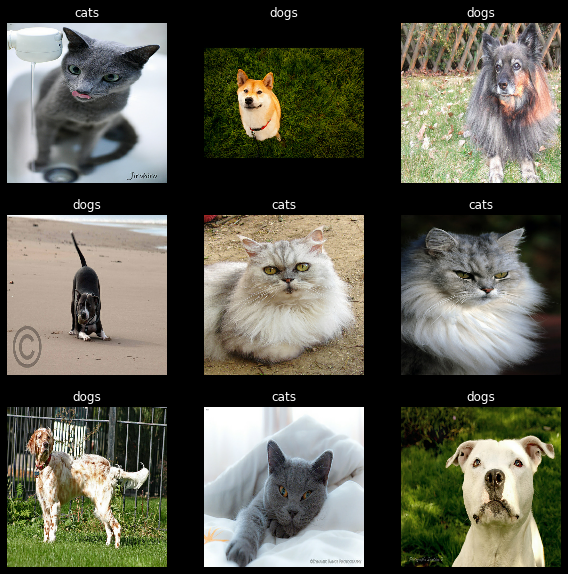

In [8]:
class_names = train_ds.class_names


fig = plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()


In [9]:
# Initializing the testing dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 7390 files belonging to 2 classes.
Using 1478 files for validation.


Again, I examine the datasets to make sure that things are as expected. Here I see that each batch has `32` images and each image is of size `(160, 160, 3)` - the third dimension is for the RGB color values.

In [10]:
for image_batch, labels_batch in train_ds:
  print("Images in a batch:", image_batch.shape[0])
  print("Labels in a batch:", image_batch.shape[0])
  print("Size of each image:", image_batch.shape[1:])
  break


Images in a batch: 32
Labels in a batch: 32
Size of each image: (160, 160, 3)


## Modelling

We create a sequential model using `tf.model.sequential`. The model consists of:

- 1 rescaling (`tf.keras.Rescaling`) block because the input values are in the range `[0,255]` whereas inputs to the `tf.keras` layers are expected to be `[0., 1.]`.
- 3 convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them
- 1 fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a `ReLU` activation function (`'relu'`)
- 1 fully-connected layer (`tf.keras.layers.Dense`) which outputs 1 binary value (since the expected output is binary - dor or cat)

This model is the same as what is used in [this Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/classification). I will expand on what these layers in another blog post.

In [12]:
%%time

# This enables prefetch and caching of images
# The AUTOTUNE parameter adjusts the buffer_size dynamically
# Details: https://www.tensorflow.org/guide/data_performance#prefetching

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Creating a sequential model taking images of shape (160, 160, 3) as input
# and giving output of shape (1,) 

num_classes = 1
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Choosing the tf.keras.optimizers.Adam with 
# the tf.keras.losses.BinaryCrossentropy loss function and
# the tf.metrics.BinaryAccuracy as metric

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Finally fitting the model to the data in train_ds 
# with val_ds as the validation dataset
# running for 10 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=0
)

print(f"Finished {epochs} epochs")
for i in history.history:
    print(f"Final {i:<20} {history.history[i][-1]:.5f}")
print()

Finished 10 epochs
Final loss                 0.05523
Final binary_accuracy      0.98021
Final val_loss             1.10491
Final val_binary_accuracy  0.77402

CPU times: user 26.5 s, sys: 718 ms, total: 27.2 s
Wall time: 25.3 s


Finally, we can extract the history of the training from `history` and visualize it. 

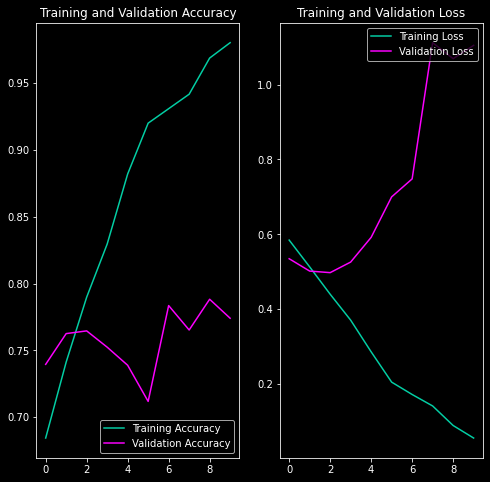

In [16]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='#fc00ff')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


If we examine the first graph, we can see that the training accuracy is skyrocketing while validation model is somewhat static. 

This is called overfitting! The model is basically memorizing the training data instead of observing higher level abstractions. We will fix that in future posts.